In [14]:
import numpy as np
from Classifiers.knn import KNN
from Classifiers.lda import LDA
from Classifiers.qda import QDA
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

# paths for folder, and for the data to use
path = os.path.abspath('') 
path_cnd_data = os.path.join(os.path.abspath(''), 'data/CATSnDOGS.csv')
path_cnd_label = os.path.join(os.path.abspath(''), 'data/Labels.csv')

# 0 is a cat, 1 is a dog
labels = pd.read_csv(path_cnd_label)
# convert to values in [0,1]?
data = pd.read_csv(path_cnd_data) # row is image number, columns are pixel values, i.e. 198x4096


[0.7575 0.72   0.51  ]
(array([  5,   8,  12,  13,  18,  25,  26,  37,  47,  50,  58,  66,  69,
        71,  77,  78,  83,  85,  88,  91,  93,  98, 102, 103, 112, 113,
       114, 117, 140, 144, 147, 151, 158, 164, 169, 171, 176, 177, 178],
      dtype=int64),) num of mislabeled images over limit: 39
(array([  8,  12,  21,  24,  37,  43,  47,  54,  66,  69,  71,  75,  77,
        78,  79,  85,  88,  93,  96, 105, 108, 112, 113, 114, 117, 133,
       143, 144, 151, 168, 170, 171, 174, 180], dtype=int64),) num of mislabeled images over limit: 34
(array([ 10,  15,  18,  19,  22,  25,  27,  31,  32,  42,  44,  47,  50,
        51,  56,  61,  65,  67,  69,  71,  73,  74,  75,  78,  81,  83,
       102, 104, 107, 108, 110, 114, 120, 123, 127, 140, 143, 161, 163,
       164, 169, 171, 176, 178, 180, 181, 185, 188, 194], dtype=int64),) num of mislabeled images over limit: 49
[ 98 176  91 171  66 169  37  85 164  83]
[105 108  24  96  93  88  85  79  21  78]


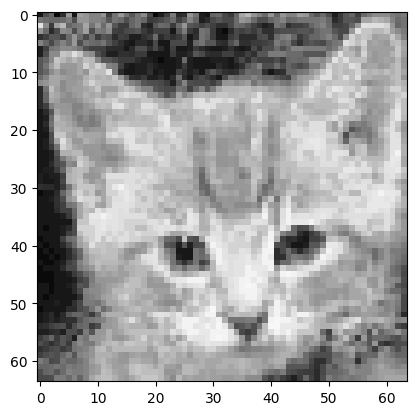

In [107]:
# initalizes all classifiers
neighbors = 10
knn = KNN(neighbors)
lda = LDA()
qda = QDA()
classifiers = [knn, lda, qda]

def prediction_fraction(test_labels, predictions): # fraction of correctly predicted labels for the data
    return sum(predictions==np.asarray(test_labels).flatten())/test_labels.size

def mislabels(test_labels, predictions, mislabeled_pics, corr_labeled_pics):
    test_indices = np.asarray(test_labels.index)
    test_labels = np.asarray(test_labels).flatten()
    comp = predictions == test_labels
    mislabeled_pics[test_indices] = ~comp + mislabeled_pics[test_indices]
    corr_labeled_pics[test_indices] = comp + corr_labeled_pics[test_indices]

    return np.squeeze(np.asarray(mislabeled_pics)), np.squeeze(np.asarray(corr_labeled_pics))

numRuns = 10
classifier_prediction_levels = np.empty((len(classifiers),numRuns))
mislabeled_pics = np.zeros((len(classifiers), len(data)))
corr_labeled_pics = np.zeros((len(classifiers), len(data)))
for i in range(numRuns):
    # split data
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, shuffle=True)

    for c in range(len(classifiers)):
        # train models and then predict test data
        classifier_model = classifiers[c].fit_data(train_data, train_labels) #trained model
        classifier_predictions = np.asarray(classifiers[c].predict(test_data,classifier_model)) #model predictions for dataset
        classifier_prediction_levels[c, i] = prediction_fraction(test_labels,classifier_predictions)

        mislabeled_pics[c,:], corr_labeled_pics[c,:] = mislabels(test_labels, classifier_predictions, mislabeled_pics[c,:], corr_labeled_pics[c,:])

classifiers_prediction_levels = np.mean(classifier_prediction_levels, axis=1)
print(classifiers_prediction_levels)

frac_mislabeled = np.divide(mislabeled_pics, np.add(mislabeled_pics, corr_labeled_pics))
lim = 0.9
print(np.where(frac_mislabeled[0]>lim), 'num of mislabeled images over limit:', sum(frac_mislabeled[0]>lim)) # knn
print(np.where(frac_mislabeled[1]>lim), 'num of mislabeled images over limit:', sum(frac_mislabeled[1]>lim)) # lda
print(np.where(frac_mislabeled[2]>lim), 'num of mislabeled images over limit:', sum(frac_mislabeled[2]>lim)) # qda

print((-frac_mislabeled[0]).argsort()[:10])
print((-frac_mislabeled[1]).argsort()[:10])

# Plot an image
datavec = np.asarray(data)
imgNumber = 0
plt.imshow(np.transpose(np.split(datavec[imgNumber],64)), cmap='gray', vmin=0, vmax=255)
plt.show()


In [84]:
# Feature selection in Cats and Dogs images
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
import numpy as np

param = {'alpha':np.linspace(0,2,100)}
lassoObj = Lasso()
gridMod = GridSearchCV(lassoObj, param, cv=5)
gridMod.fit(data, labels) # 10-fold cross-validate for each C to find a C for lasso regression that predicts a good set of valuable features
alphaVal = gridMod.best_params_['alpha']

In [88]:
boolMatrix = np.zeros((4096, ))
thresh = 0.0001
numOfRuns = 1000
for i in range(numOfRuns):
    lassoObj  = Lasso(alpha=alphaVal)
    #data_ss = data[np.random.randomint(ceil(0.8*N))]
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, shuffle=True)
    lassoObj.fit(train_data, train_labels)
    boolMatrix = boolMatrix + lassoObj.coef_ > thresh
featLasso = boolMatrix

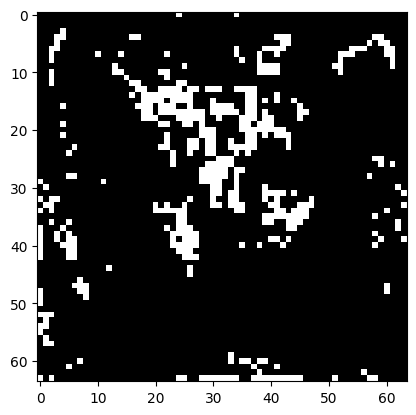

In [89]:
plt.imshow(featLasso.reshape((64,64),order='F'),cmap='gray')

In [104]:
dat = np.asarray(data)
featData = dat[:,boolMatrix]


In [106]:
neighbors = 10
knn = KNN(neighbors)
lda = LDA()
qda = QDA()
classifiers = [knn, lda, qda]

def prediction_fraction(test_labels, predictions): # fraction of correctly predicted labels for the data
    return sum(predictions==np.asarray(test_labels).flatten())/test_labels.size

numRuns = 1000
classifier_prediction_levels = np.empty((len(classifiers),numRuns))
mislabeled_pics = np.zeros((len(classifiers), len(data)))
corr_labeled_pics = np.zeros((len(classifiers), len(data)))
for i in range(numRuns):
    # split data
    train_data, test_data, train_labels, test_labels = train_test_split(featData, labels, test_size=0.2, shuffle=True)

    for c in range(len(classifiers)):
        # train models and then predict test data
        classifier_model = classifiers[c].fit_data(train_data, train_labels) #trained model
        classifier_predictions = np.asarray(classifiers[c].predict(test_data,classifier_model)) #model predictions for dataset
        classifier_prediction_levels[c, i] = prediction_fraction(test_labels,classifier_predictions)

        #mislabeled_pics[c,:], corr_labeled_pics[c,:] = mislabels(test_labels, classifier_predictions, mislabeled_pics[c,:], corr_labeled_pics[c,:])

classifiers_prediction_levels = np.mean(classifier_prediction_levels, axis=1)
print(classifiers_prediction_levels)

[0.74875 0.49725 0.535  ]
